**Project Aim** <br>
This notebooks is to apply Support Vector Machines to a Classification problem

Develop a model using Support Vector Machine which should correctly classify the handwritten digits from 0-9 based on the pixel values given as features. Thus, this is a 10-class classification problem.

**Project Assumptions**

**Project Objective**
- Basic EDA of the MNIST Dataset
    - How should pixal data be analysed?
    - Use new plots from Seaborn
    - Implement groupby functions in pandas to analyse different data aggregations
    - What columns are identical or have very similar distributions?
    - Outlier analysis and associated impact
- Implement one solution to reduce dimensionality
- Understand the framework of support vector machines 
    - Build a model that overfits a small proporion of the dataset and how to reach this conclusion
    - Understand methods to select features for classification problems
    - Include bias/variance trade off analysis
    - liblinear and libvsm libraries 
    - Cross Validation Strategy (LOO_CV)
    - Sci-Kit Learns Transformation Pipeline (page 66 - Hands on ML with Sci-kit Learn sklearn.pipeline import Pipeline)
- Application of multiple Kernal Types and model performance analysis
- Understand and apply an appropriate loss function 
    - Hinge Loss
- Feature Selection/Scaling
    - Add randomised features
    - Implement Scaling/Normalisation using Sci-kit learn Pipeline
- Hyperparameter Tuning (Implement and understand grid search plus evaluate where the model over/underfits)
    - Grid Search for parameters (page 72 - Hands on ML): Determine which parameters need to be optimised 
- Understand how explainability may be applied to SVM Classification problems
- Investigate if SVM model can be plotted 
    - Error evaluation: Where does the system commonly make mistakes and how can this be improved?
- Dockerise the solution 
- Document brief conclusions 
    - Think where bias might be incorporated in the model and how this can be treated --- Poor quality measures?
    - What is the scope that the model can predict and where could it have issues generalising e.g. new categories?
- Document and understand 3 key learningd from other kaggle solutions

**Support Vector Machine Notes**
- Hands-On Machine Learning with Scikit-Learn & Tensorflow
- Mastering Predictive Analytics with R
- Andrew Ng SVM <br>
https://www.youtube.com/watch?v=XfyR_49hfi8&list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN&index=74

**Parameters**
- Choice of parameter C
- Choice of kernel (similarity function)
    - Linear SVM uses no Kernel: Standard linear classifier (use when large number of features but small dataset)
    - Gaussian: Will require selection of parameter sigma^2 (use when small number of features but large training set)
        - **Perform feature scaling before implementing a gaussian kernel**

**Algorithm Performance on MNIST Dataset**
- Benchmark Model:
- Optimal Performance (Personal): 
- Optimal Performance (Kaggle): Error rates as low as 0.23% (99.77 Accuracy)

**References** <br>
https://www.researchgate.net/publication/230800948_The_Secrets_to_Managing_Business_Analytics_Projects <br>
https://towardsdatascience.com/an-intro-to-kernels-9ff6c6a6a8dc <br>
https://towardsdatascience.com/visualizing-statistical-plots-with-seaborn-6b6e60ce5e71 <br>
https://medium.com/analytics-vidhya/5-lesser-known-seaborn-plots-most-people-dont-know-82e5a54baea8 <br>
https://towardsdatascience.com/11-examples-to-master-pandas-groupby-function-86e0de574f38 <br>
https://machinelearningmastery.com/feature-selection-subspace-ensemble-in-python/ <br>
https://towardsdatascience.com/one-potential-cause-of-overfitting-that-i-never-noticed-before-a57904c8c89d <br>
https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/ <br>
https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/ <br>
https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

In [102]:
import os
import pandas as pd

In [103]:
os.getcwd()

'/Users/Rej1992/Documents/GitHub/SupportVectorMachines/notebooks'

In [104]:
train_data = pd.read_csv('/Users/Rej1992/Desktop/SVM_Data/mnist_train.csv')
test_data = pd.read_csv('/Users/Rej1992/Desktop/SVM_Data/mnist_test.csv')

In [105]:
# Create a representative sample of the data set
import random
import numpy as np

train_data = train_data.sample(n = 2000, replace = False) 
test_data = test_data.sample(n = 2000, replace = False) 

In [106]:
# Remove duplicated columns 
train_data = train_data.loc[:,~train_data.columns.duplicated()]
test_data = test_data.loc[:,~test_data.columns.duplicated()]

In [107]:
def _remove_columns_unique_values(data):
    
    nunique = data.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    
    return data.drop(cols_to_drop, axis=1)

test_data = _remove_columns_unique_values(test_data)
train_data = _remove_columns_unique_values(train_data)

In [108]:
# Check column overlap
print(test_data.columns.difference(train_data.columns))
print(train_data.columns.difference(test_data.columns))

Index(['11x1', '11x28', '12x1', '12x28', '13x2', '14x2', '17x2', '19x28',
       '20x28', '24x2', '2x6', '2x7', '4x27', '6x2'],
      dtype='object')
Index(['18x2', '19x1', '1x13', '1x14', '1x15', '1x16', '20x1', '22x2', '23x2',
       '25x3', '2x22', '2x23', '2x24', '3x26', '3x4', '3x5', '4x4', '8x1',
       '9x1'],
      dtype='object')


In [109]:
# Retain only columns that exist in the test data set
train_data = train_data.drop(train_data.columns.difference(test_data.columns), axis=1)
test_data = test_data.drop(test_data.columns.difference(train_data.columns), axis=1)

In [110]:
# Verfiy the data type 
train_data.dtypes.unique()

array([dtype('int64')], dtype=object)

In [111]:
# Remove missing targets
train_data = train_data[train_data.label.notnull()]

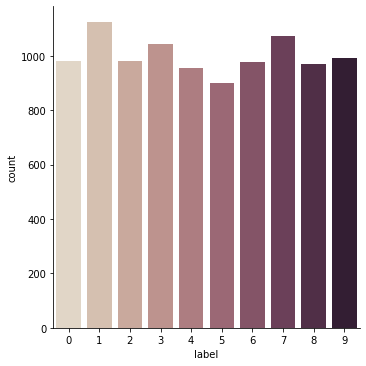

In [112]:
# Analyse the distribution of the target
import seaborn as sns
sns.catplot(x="label", kind="count", palette="ch:.25", data=train_data)

In [113]:
train_data.std().sort_values(ascending=False).head(10)

15x15    113.986892
14x15    113.539086
17x14    113.061911
17x15    112.927888
16x14    112.927043
16x15    112.795280
23x12    112.645162
7x15     112.469078
16x18    112.464024
23x15    112.440427
dtype: float64

In [114]:
train_data = train_data[['label', '14x15', '15x15', '23x12', '23x13', '17x14', '15x18', '16x14', '16x18', '7x16', '7x15']]

In [115]:
train_data.describe()

,label,14x15,15x15,23x12,23x13,17x14,15x18,16x14,16x18,7x16,7x15
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.46000,110.727700,129.835300,112.217800,121.276600,115.142800,129.776500,121.990400,122.047200,125.926500,119.930600
std,2.88857,113.539086,113.986892,112.645162,112.417357,113.061911,112.405421,112.927043,112.464024,112.244043,112.469078
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.00000,64.000000,143.000000,78.000000,115.000000,87.000000,146.000000,115.000000,116.000000,132.000000,114.000000
75%,7.00000,252.000000,253.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
max,9.00000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [116]:
train_data.isnull().sum()

label    0
14x15    0
15x15    0
23x12    0
23x13    0
17x14    0
15x18    0
16x14    0
16x18    0
7x16     0
7x15     0
dtype: int64

In [119]:
# Feature Engineering 
## Normalisation/Standardisation
## Discretise continuous variables 
## Feature transformations and interactions (product/sum etc.)
## Create a set of randomised features 

In [134]:
# spot check machine learning algorithms on the adult imbalanced dataset
# https://machinelearningmastery.com/imbalanced-classification-with-the-adult-income-dataset/
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

In [141]:
# Establish X and y & label encode the target variable to have the classes 0 and 1
y = LabelEncoder().fit_transform(train_data.label)
X = train_data.drop('label', 1)
num_ix = X.select_dtypes(include=['int64', 'float64']).columns

In [142]:
# Create a benchmark duummy model


In [143]:
# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    
    return scores

In [144]:
# Define models to test: Support Vector Machine 
def get_models():
    models, names = list(), list()
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    
    # GBM
    models.append(GradientBoostingClassifier(n_estimators=100))
    names.append('GBM')
    
    return models, names

>SVM 0.579 (0.014)
>GBM 0.609 (0.013)


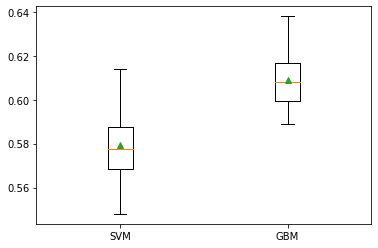

In [145]:
# define models
models, names = get_models()
results = list()

# evaluate each model
for i in range(len(models)):
    # define steps
    steps = [('n',MinMaxScaler(), num_ix)]
    
    # one hot encode categorical, normalize numerical
    ct = ColumnTransformer(steps)
    
    # wrap the model i a pipeline
    pipeline = Pipeline(steps=[('t',ct),('m',models[i])])
    
    # evaluate the model and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
    
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()